In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import pyLDAvis.gensim

import os, re, operator, warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Read in csv file then prepare the text to be processed by concatting all the comments in the dataframe as a single document where comments are separated by the newline character.

In [2]:
df = pd.read_csv('/Users/kevinmacmat/Documents/flatiron/module_projects/capstone/csv/comments_metadata.csv')

In [3]:
text = df['comment'].str.cat(sep='\n')

Import Spacy's English Language pipeline and process the text and save as the "doc" variable.

In [4]:
from spacy.lang.en import English
nlp = spacy.load('en_core_web_md')
# Because of the size of the "text" we need to increase the max length. Before running, make sure
# your computer has enough free ram (rougly 1GB per 1,000,000 length).
nlp.max_length = 10000000

In [5]:
my_stop_words = [u'school', u'schools', u'PS', u'read_<', u'teacher', u'teachers', u'Teacher', u'Teachers', u'child', u'children', 
                 u'parent', u'parents', u'Parent', u'Parents', u'guardian', u'guardians', u'new', u'city', u'york', u'student', u'students',
                 u'class', u'hi', u'be', u'like', u'great', u'know', u'go', u'Go', u'kid', u'kids', u'say', u'href="http://schools.nyc.gov_Offices',
                 u'\xa0 \n', u'\xa0\n', u'\xa0 ', u'<_/P', u'<_/p', u'n\n', u'son', u'daughter', u'u', u'ur', u'ms.', u'Ms.', u'mr.',
                 u'Mr.', u' ', u'Student', u'Students',]
for stopword in my_stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

In [6]:
doc = nlp(text)

In [7]:
# we add some words to the stop word list
texts, article = [], []
for word in doc:
    # if the word is not a stop word, punctuation, or number
    if word.text != '\n' and not word.is_stop and not word.is_punct and not word.like_num:
        # append lemmatized word to article container
        article.append(word.lemma_)
        # if newline then signals end of the document
    if word.text == '\n':
        texts.append(article)
        article = []

---

**The pipeline begins with a database populated with comments in the comment column.**

In [8]:
df.comment.iloc[1]

"A Hidden Gem!Amazing community school that feels like an extension to my family. Teachers and staff are amazing and friendly. They genuinely care about my kids, their progress and overall well-being. A chapter of my son's life and mine is ending as he is graduating this year. I truly appreciate the Principal's leadership Irene Sanchez, the Parent Coordinator La'Nette Murphy, the school nurse Ms. Brenda and all the teachers and staff that made a difference in my kids life. Shout out to the Science Teacher Ms. Sullivan, the Technology Teacher Ms. Sacks, the Gym Teachers Coach D, Coach Ramirez. Thank you to the  teachers Mrs. Segal, Ms. Mendolia, Ms. Lazar, Ms. Rice, Ms. Lennon, Ms. Burns and Ms. Rosario. Thank you P.S.15."

**The pandas series is then parsed and each user comment is concatted together with the newline character to indicate separate documents.**

In [9]:
text[:3000]

'P.S. 15 is an extraordinary small school that goes to extraordinary lengths to engage and care for their children. The principal, Irene Sanchez, leads an incredible group of attentive teachers and administrators who are dedicated to providing a safe, caring, and exciting environment for children to learn. The G&T program is enrichment based (not "accelerated") and has re-instilled a sheer joy of learning in our child, which is a priority for us as a family. Of the many enrichments, the kids have a dedicated STEAM teacher, dedicated Science teacher, special interest classes that the children choose every Friday, a wonderful music class, and 2nd graders attend swimming once a week at Asphalt Green. There are also many field trips and hands on, project-based learning opportunities. The children have an amazing playground attached to the school and are allowed to play outside before and after school and during recess. They also have a great gym and have gym class three times a week. The s

**A stopwords list is created then the text document is passed into spacy's pipeline to create the "doc". The doc object is a list of spacy tokens with inherent properties given to each token by the spacy pipeline.**  

In [10]:
print('{} {}\n'.format('Doc Index 0:', doc[0]))
print('{} {}'.format('Data Type: ', type(doc[0])))

Doc Index 0: P.S.

Data Type:  <class 'spacy.tokens.token.Token'>


In [11]:
doc[370:517]


A Hidden Gem!Amazing community school that feels like an extension to my family. Teachers and staff are amazing and friendly. They genuinely care about my kids, their progress and overall well-being. A chapter of my son's life and mine is ending as he is graduating this year. I truly appreciate the Principal's leadership Irene Sanchez, the Parent Coordinator La'Nette Murphy, the school nurse Ms. Brenda and all the teachers and staff that made a difference in my kids life. Shout out to the Science Teacher Ms. Sullivan, the Technology Teacher Ms. Sacks, the Gym Teachers Coach D, Coach Ramirez. Thank you to the  teachers Mrs. Segal, Ms. Mendolia, Ms. Lazar, Ms. Rice, Ms. Lennon, Ms. Burns and Ms. Rosario. Thank you P.S.15.

**The doc object is then iterated through and if the word is not a stop word, punctuation, or number it is appended to a list called article. When the loop hits a newline character the article list is then then appended to a list called texts which becomes a list of lists containing the lemmatized words.**

In [12]:
# Check to see if still contains the word teacher.
texts[1]

['hidden',
 'gem!amazing',
 'community',
 'feel',
 'extension',
 'family',
 'staff',
 'amazing',
 'friendly',
 'genuinely',
 'care',
 'kid',
 'progress',
 'overall',
 'chapter',
 'life',
 'end',
 'graduate',
 'year',
 'truly',
 'appreciate',
 'Principal',
 'leadership',
 'Irene',
 'Sanchez',
 'Parent',
 'Coordinator',
 "La'Nette",
 'Murphy',
 'nurse',
 'Ms.',
 'Brenda',
 'staff',
 'difference',
 'kid',
 'life',
 'shout',
 'Science',
 'Ms.',
 'Sullivan',
 'Technology',
 'Ms.',
 'Sacks',
 'Gym',
 'Coach',
 'D',
 'Coach',
 'Ramirez',
 'thank',
 'Mrs.',
 'Segal',
 'Ms.',
 'Mendolia',
 'Ms.',
 'Lazar',
 'Ms.',
 'Rice',
 'Ms.',
 'Lennon',
 'Ms.',
 'Burns',
 'Ms.',
 'Rosario',
 'thank',
 'P.S.15']

In [13]:
article[0]

'locate'

In [14]:
doc[0]

P.S.

In [15]:
# first article, first 5 lemmatized words
texts[2][:]

['improved', 'state', 'English', 'math', 'test', 'score']

In [16]:
print('{} {}'.format('Length of article:', len(article)))
print(article[:4])

Length of article: 4
['locate', 'Bushwick', 'East', 'NY']


---

In [17]:
bigram = gensim.models.Phrases(texts)

In [18]:
texts = [bigram[line] for line in texts]

In [19]:
# looking at "texts" we can see the bigrams joined with an underscore
# texts

In [20]:
# create gensim.corpora.dictionary.Dictionary
dictionary = Dictionary(texts)
# create a corpus using bag of words
corpus = [dictionary.doc2bow(text) for text in texts]

In [21]:
# looking at "corpus" we can see a list of lists containing tuples for each word's index and count
# corpus

**LDA TOPIC MODEL**

In [22]:
ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [23]:
ldamodel.show_topics()

[(0,
  '0.013*"read" + 0.013*"scholar" + 0.013*"hi" + 0.013*"thank" + 0.011*"be" + 0.010*"program" + 0.008*"School" + 0.008*"Academy" + 0.008*"rank" + 0.008*"good"'),
 (1,
  '0.023*"date" + 0.019*"student" + 0.017*"read" + 0.013*"Staten_Island" + 0.010*"discipline_problem" + 0.009*"tell_Insideschools" + 0.008*"Chancellor" + 0.008*"year" + 0.007*"guy" + 0.006*"Parents"'),
 (2,
  '0.033*"good" + 0.026*"love" + 0.019*"write" + 0.016*"go" + 0.015*"kid" + 0.014*"year" + 0.012*"student" + 0.011*"child" + 0.011*"help" + 0.011*"learn"'),
 (3,
  '0.044*"read" + 0.039*"student" + 0.019*"New_York" + 0.014*"report" + 0.012*"City" + 0.009*"article" + 0.008*"program" + 0.007*"School" + 0.007*">" + 0.006*"JHS"'),
 (4,
  '0.032*"child" + 0.017*"parent" + 0.016*"principal" + 0.012*"student" + 0.009*"change" + 0.009*"staff" + 0.009*"Ms." + 0.009*"go" + 0.008*"kid" + 0.008*"write"'),
 (5,
  '0.036*"student" + 0.013*"work" + 0.012*"staff" + 0.011*"year" + 0.009*"parent" + 0.009*"write" + 0.009*"child" + 0

**HDP TOPIC MODEL**

In [24]:
hdpmodel = HdpModel(corpus=corpus, id2word=dictionary)

In [25]:
hdpmodel.show_topics()

[(0,
  '0.017*student + 0.010*year + 0.009*kid + 0.009*child + 0.009*parent + 0.008*good + 0.006*principal + 0.006*go + 0.006*program + 0.005*time + 0.005*work + 0.005*staff + 0.005*write + 0.005*help + 0.005*say + 0.005*learn + 0.005*need + 0.004*grade + 0.004*love + 0.004*get'),
 (1,
  '0.017*student + 0.010*year + 0.009*kid + 0.009*good + 0.009*parent + 0.009*child + 0.006*principal + 0.006*go + 0.006*time + 0.005*work + 0.005*program + 0.005*staff + 0.005*write + 0.005*need + 0.005*say + 0.004*learn + 0.004*help + 0.004*grade + 0.004*want + 0.004*come'),
 (2,
  '0.015*student + 0.009*year + 0.009*kid + 0.008*good + 0.008*parent + 0.008*child + 0.007*principal + 0.006*go + 0.005*write + 0.005*program + 0.005*time + 0.005*work + 0.004*say + 0.004*learn + 0.004*staff + 0.004*love + 0.004*need + 0.004*help + 0.004*grade + 0.004*get'),
 (3,
  '0.014*student + 0.008*good + 0.008*year + 0.008*kid + 0.007*parent + 0.006*child + 0.005*principal + 0.005*go + 0.004*program + 0.004*write + 0.0

**LSI TOPIC MODEL**

In [26]:
lsimodel = LsiModel(corpus=corpus, num_topics=10, id2word=dictionary)

In [27]:
lsimodel.show_topics(num_topics=5)

[(0,
  '0.487*"student" + 0.256*"year" + 0.244*"kid" + 0.226*"parent" + 0.206*"child" + 0.202*"good" + 0.140*"work" + 0.139*"time" + 0.131*"go" + 0.131*"principal"'),
 (1,
  '-0.797*"student" + 0.422*"kid" + 0.193*"child" + 0.182*"parent" + 0.145*"good" + 0.093*"go" + 0.074*"love" + 0.073*"year" + 0.069*"principal" + 0.069*"time"'),
 (2,
  '0.690*"child" + -0.456*"kid" + 0.337*"parent" + -0.225*"good" + -0.105*"year" + 0.095*"principal" + -0.084*"bad" + -0.073*"high" + -0.072*"grade" + 0.072*"staff"'),
 (3,
  '-0.585*"kid" + 0.578*"year" + -0.294*"parent" + -0.234*"student" + 0.219*"good" + 0.144*"go" + 0.077*"graduate" + 0.076*"amazing" + 0.065*"high" + 0.064*"teach"'),
 (4,
  '-0.612*"good" + 0.530*"year" + 0.232*"kid" + -0.220*"principal" + -0.157*"say" + 0.144*"program" + -0.115*"go" + -0.114*"bad" + 0.101*"middle" + -0.098*"thing"')]

**TOPIC COHERENCE** <br><br>
A coherence value is a way to compare topic models using a numerical value.

In [28]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]
hdptopics = [[word for word, prob in topic] for topicid, topic in hdpmodel.show_topics(formatted=False)]
ldatopics = [[word for word, prob in topic] for topicid, topic in ldamodel.show_topics(formatted=False)]

In [29]:
lsi_coherence = CoherenceModel(topics=lsitopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
hdp_coherence = CoherenceModel(topics=hdptopics[:10], texts=texts, dictionary=dictionary, window_size=10).get_coherence()
lda_coherence = CoherenceModel(topics=ldatopics, texts=texts, dictionary=dictionary, window_size=10).get_coherence()

In [30]:
def evaluate_bar_graph(coherences, indices):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    indices: Indices to be used to mark bars. Length of this and coherences should be equal.
    """
    assert len(coherences) == len(indices)
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width = 0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

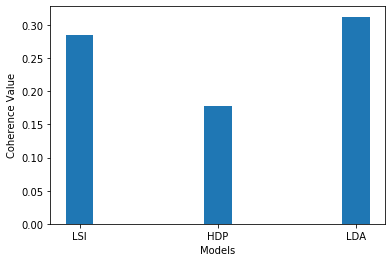

In [31]:
evaluate_bar_graph([lsi_coherence, hdp_coherence, lda_coherence], ['LSI', 'HDP', 'LDA'])

**pyLDAvis**

In [32]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.154314 -0.019233       1        1  24.865845
5      0.115534  0.049744       2        1  22.108850
2      0.153401 -0.046835       3        1  18.844931
4      0.119534 -0.025955       4        1   9.123249
8      0.027938  0.010702       5        1   7.257949
7      0.084723 -0.012918       6        1   6.603981
3     -0.135743  0.224015       7        1   5.391191
1     -0.096884 -0.012945       8        1   2.092424
0     -0.176687 -0.050999       9        1   2.070230
9     -0.246129 -0.115576      10        1   1.641358, topic_info=                   Term          Freq         Total Category  logprob  loglift
206                read   2877.000000   2877.000000  Default  30.0000  30.0000
193             student  11890.000000  11890.000000  Default  29.0000  29.0000
190                 say   4106.000000   4106.000000  Default  28.0000  28.0000
82            principal   4547.000000   4547.000000  Default  27.0000  27.0000
234                love   3439.000000   3439.000000  Default  26.0000  26.0000
...                 ...           ...           ...      ...      ...      ...
157           Education     56.958549    256.238190  Topic10  -5.1201   2.6059
3154  Chancellor_Carmen     39.552452     67.828133  Topic10  -5.4848   3.5703
193             student     63.194740  11890.443359  Topic10  -5.0162  -1.1276
144                year     49.235531   6561.835449  Topic10  -5.2658  -0.7828
1762            Academy     39.668312    213.685120  Topic10  -5.4819   2.4257

[726 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
1022       5  0.949773          \t
1022      10  0.044175          \t
1113       1  0.065599          \n
1113       2  0.123247          \n
1113       3  0.186859          \n
...      ...       ...         ...
144        9  0.014173        year
144       10  0.007467        year
12899      3  0.984438  year_newly
2849       3  0.089265           😊
2849       8  0.892652           😊

[2177 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 3, 5, 9, 8, 4, 2, 1, 10])